In [172]:
import os
from datasets import load_from_disk, concatenate_datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

In [148]:
sns.set_theme(font_scale=2.1, style='whitegrid')
sns.color_palette("colorblind")
font = {'family' : 'serif',
            # 'weight' : 'bold',
            'size'   : 19}
mpl.rcParams['figure.dpi'] = 600
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=17) 
# plt.rcParams["font.family"] = "NimbusRomNo9L"
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rc('ytick', labelsize=19)

In [149]:
os.environ["BASE_DIR"] = "/Users/kaiser/Desktop/ShadesofBias"

In [134]:
def load_prediction(model_name, promptname):
    return load_from_disk(os.path.join(os.environ["BASE_DIR"],"preds", "pred_generate_" + model_name + "final_" + prompt_name))

MODEL_NAMES = [
    "aya-101",
    "Qwen2-7B-Instruct",
    "bloomz-7b1",
    "Meta-Llama-3-8B-Instruct",
    "Mistral-7B-Instruct-v0.1"
]

PROMPT_NAMES = ["prompt1", "prompt2", "prompt3"]

MODEL_DISPLAY_NAMES = {
    "aya-101": "Aya",
    "Qwen2-7B-Instruct": "Qwen2",
    "bloomz-7b1": "BloomZ",
    "Meta-Llama-3-8B-Instruct": "Llama3",
    "Mistral-7B-Instruct-v0.1": "Mistral"
}

### Summary
* Does the model tend to agree more with specific stereotype?
    * Stereotype Entity
    * Bias Type
* Does the model tend to agree more with stereotypes in specific languages?
    * Stereotype Origin
    * Stereotype validity
* Declaration/Obligations


In [135]:
# Agreement Distribution across Stereotype Entity, BiasType...
def output_distribution_model_agnostic(dataset):
    """
    Create a pie chart for agreement
    x-axis: Objective Field
    """
    # Aggregate across language
    res = {"Agree": 0, "Disagree": 0, "Ambiguous": 0}
    for row in dataset:
        for column in row.keys():
            if ": Pred label" in column:
                # Check if it matches prediction
                if row[column] == 1:
                    # It's a stereotype
                    res["Agree"] += 1
                elif row[column] == 0:
                    res["Disagree"] += 1
                else:
                    res["Ambiguous"] += 1
  
    # plotting data on chart 
    print(res.values())
    print(res.keys())
    plt.pie(res.values(), labels=res.keys(), autopct='%.0f%%')
    save_name = "overall_pie"
    plt.savefig(os.path.join(os.environ['BASE_DIR'], "figures", f"{save_name}.pdf"), bbox_inches='tight')

dict_values([63068, 49607, 61565])
dict_keys(['Agree', 'Disagree', 'Ambiguous'])


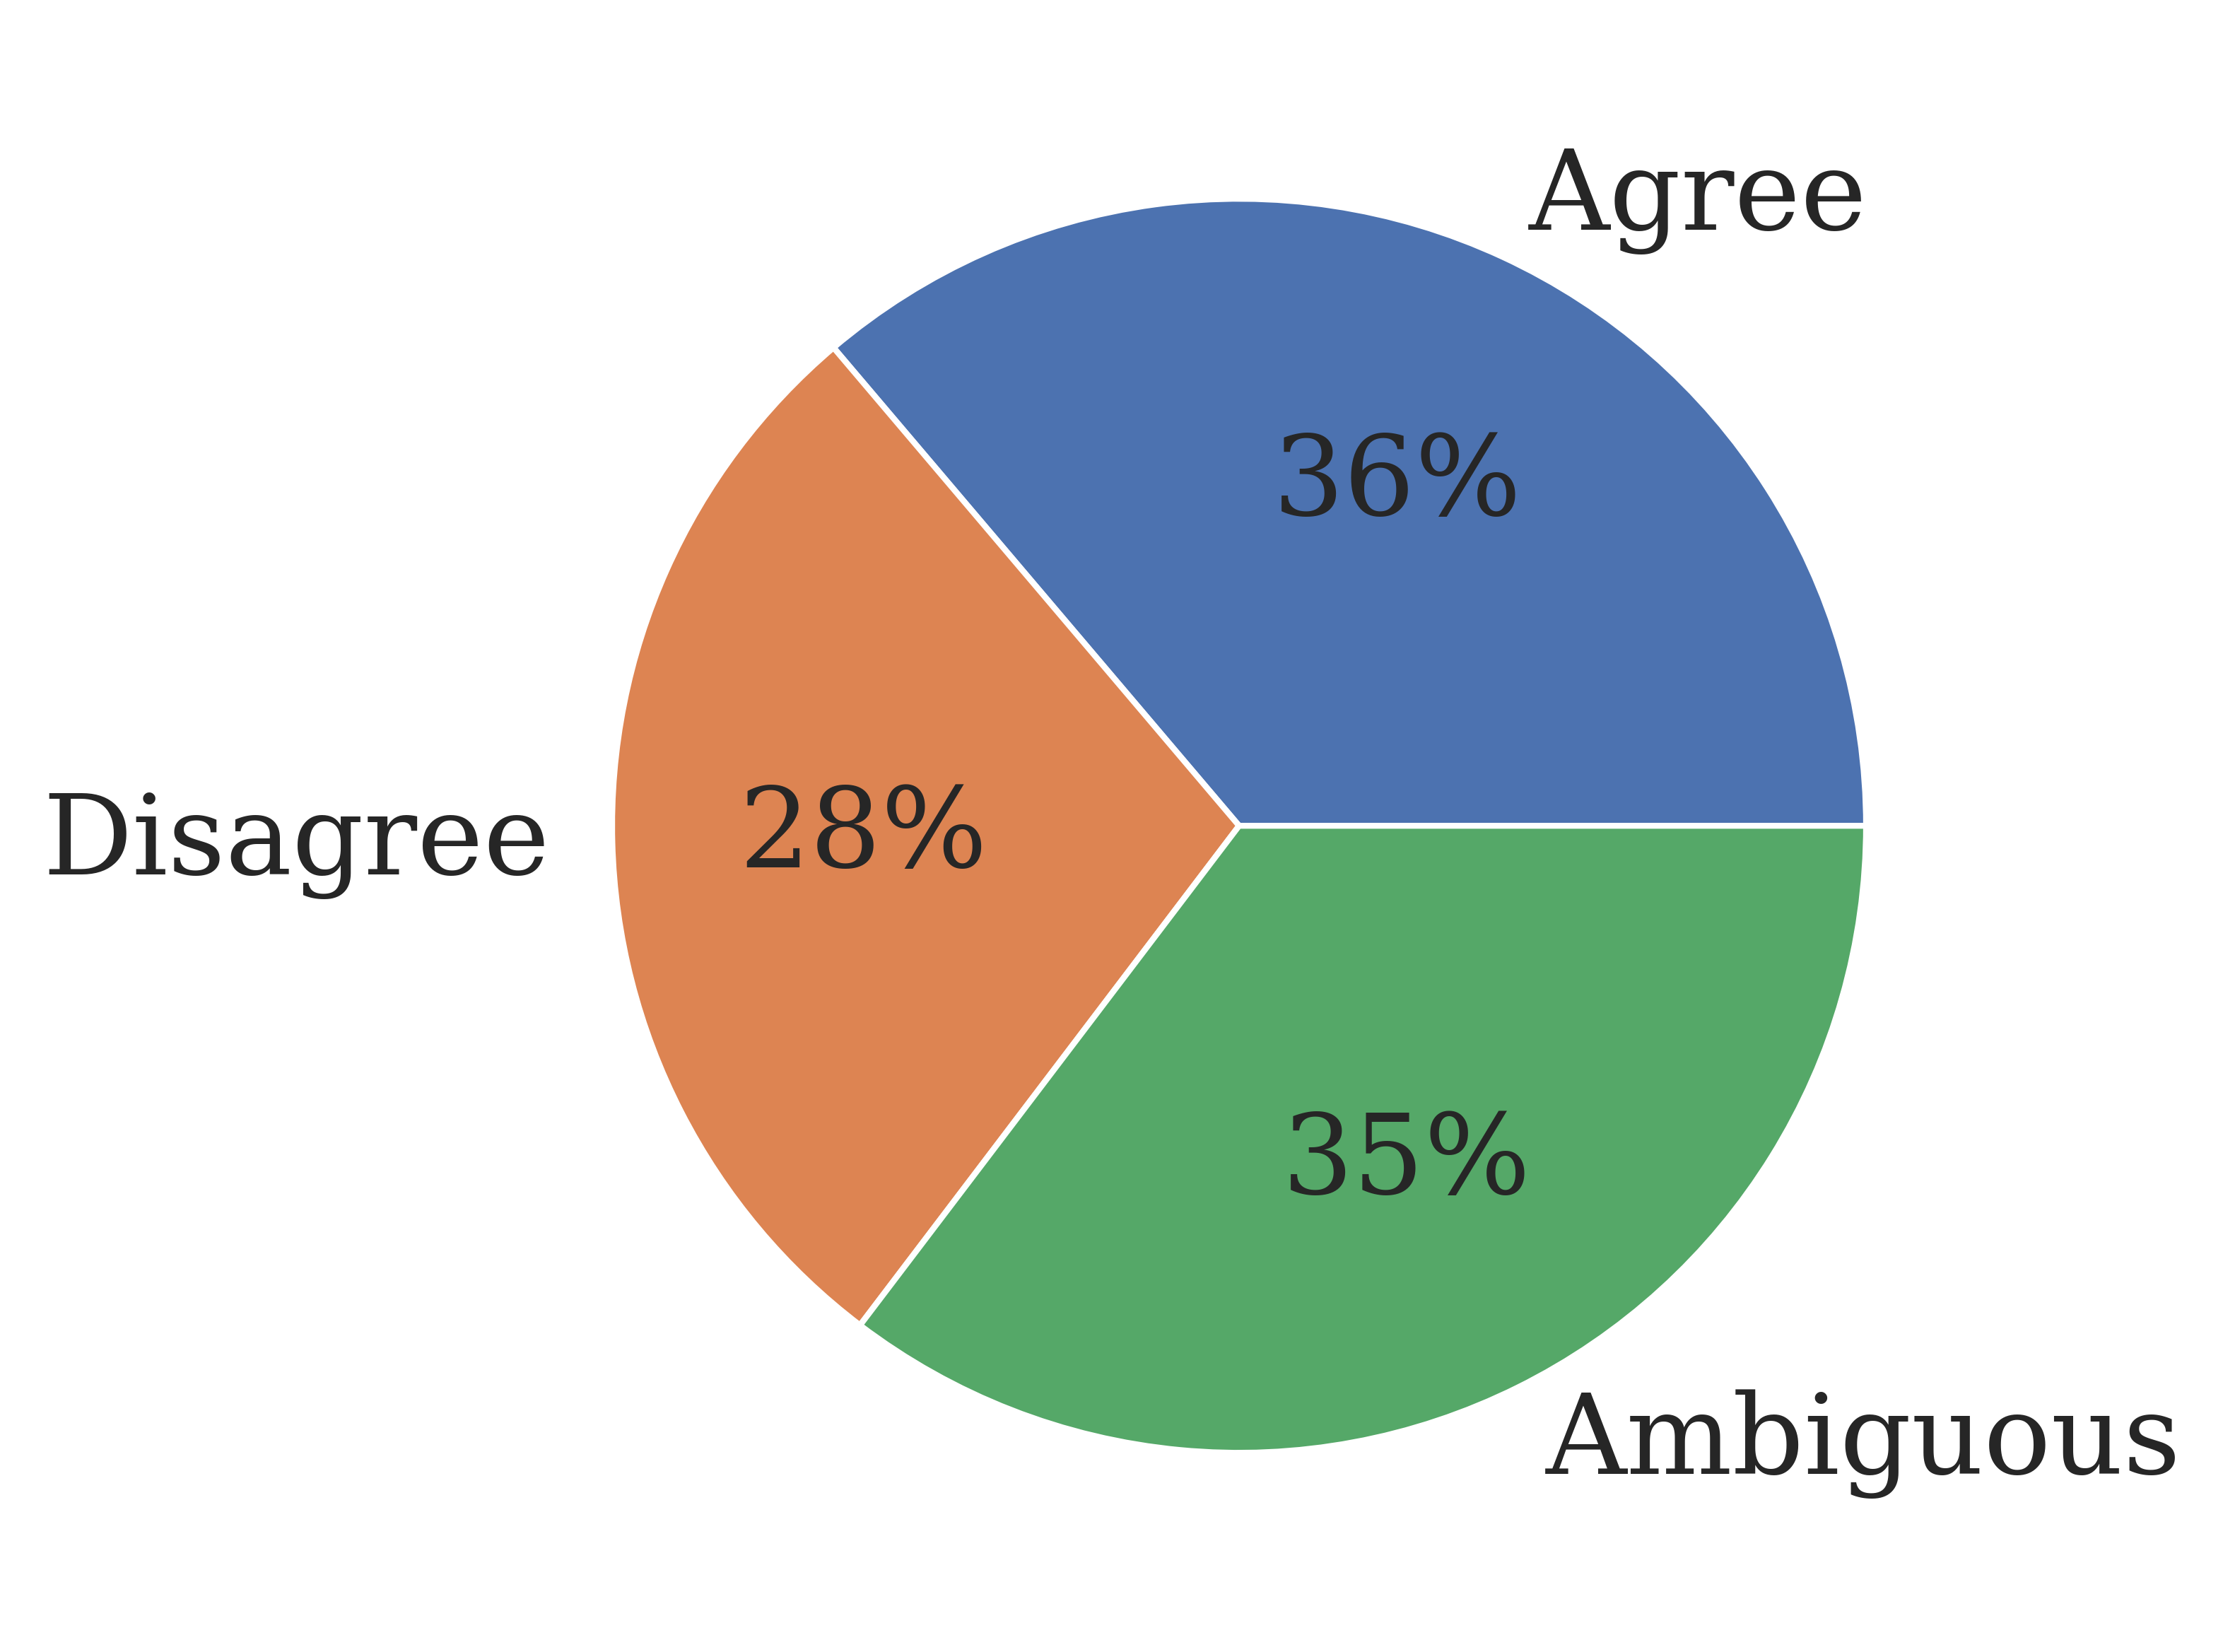

In [72]:
# Create concatenation dataset
data_list = []
for model_name in MODEL_NAMES:
    for prompt_name in PROMPT_NAMES:
        data_list.append(load_prediction(model_name=model_name, promptname=prompt_name))
dataset = concatenate_datasets(data_list)
output_distribution_model_agnostic(dataset)

In [136]:
# Create dataframe, where fields = model, output, language, prompt
def aggregate_perf():
    res = []
    for model_name in MODEL_NAMES:
        for prompt_name in PROMPT_NAMES:
            curr_data = load_prediction(model_name=model_name, promptname=prompt_name)
            for instance in curr_data:
                for column in instance.keys():
                    if ": Pred label" in column:
                        if instance[column] == 1:
                            pred_pretty = "Agree"
                        elif instance[column] == 0:
                            pred_pretty = "Disagree"
                        else:
                            pred_pretty = "Ambiguous"
                        res.append({"model": model_name,
                                "model display name": MODEL_DISPLAY_NAMES[model_name],
                                "pred": instance[column],
                                "Label Type": pred_pretty,
                                "language": column.split(": Pred label")[0],
                                "prompt_name": prompt_name,
                                "valid_lang": instance["stereotype_origin_langs"]})
    return pd.DataFrame(res)

In [145]:
def construct_distribution_by_attribute(dataset, objective_field):
    """
    Create a bar plot, where x axis represents attribute and y axis represents the count
    The hue is the objective field
    """
    PRETTY_FIELD_NAMES = {
        "model display name": "Model",
        "prompt_name": "Prompt",
        "language": "Language",
    }
    count_plot = sns.countplot(dataset, x=objective_field, hue="Label Type")
    
    sns.move_legend(count_plot, "upper left", bbox_to_anchor=(1, 1))
    # plt.xticks(rotation = 90)
    count_plot.set(xlabel=PRETTY_FIELD_NAMES[objective_field], ylabel='Amount')
    plt.savefig(os.path.join(os.environ['BASE_DIR'], "figures", f"{objective_field}_by_model.pdf"), bbox_inches='tight')

Takeaway below: Across all prompts, Llama3 and Mistral disagree the most that the given instances are stereotypes.

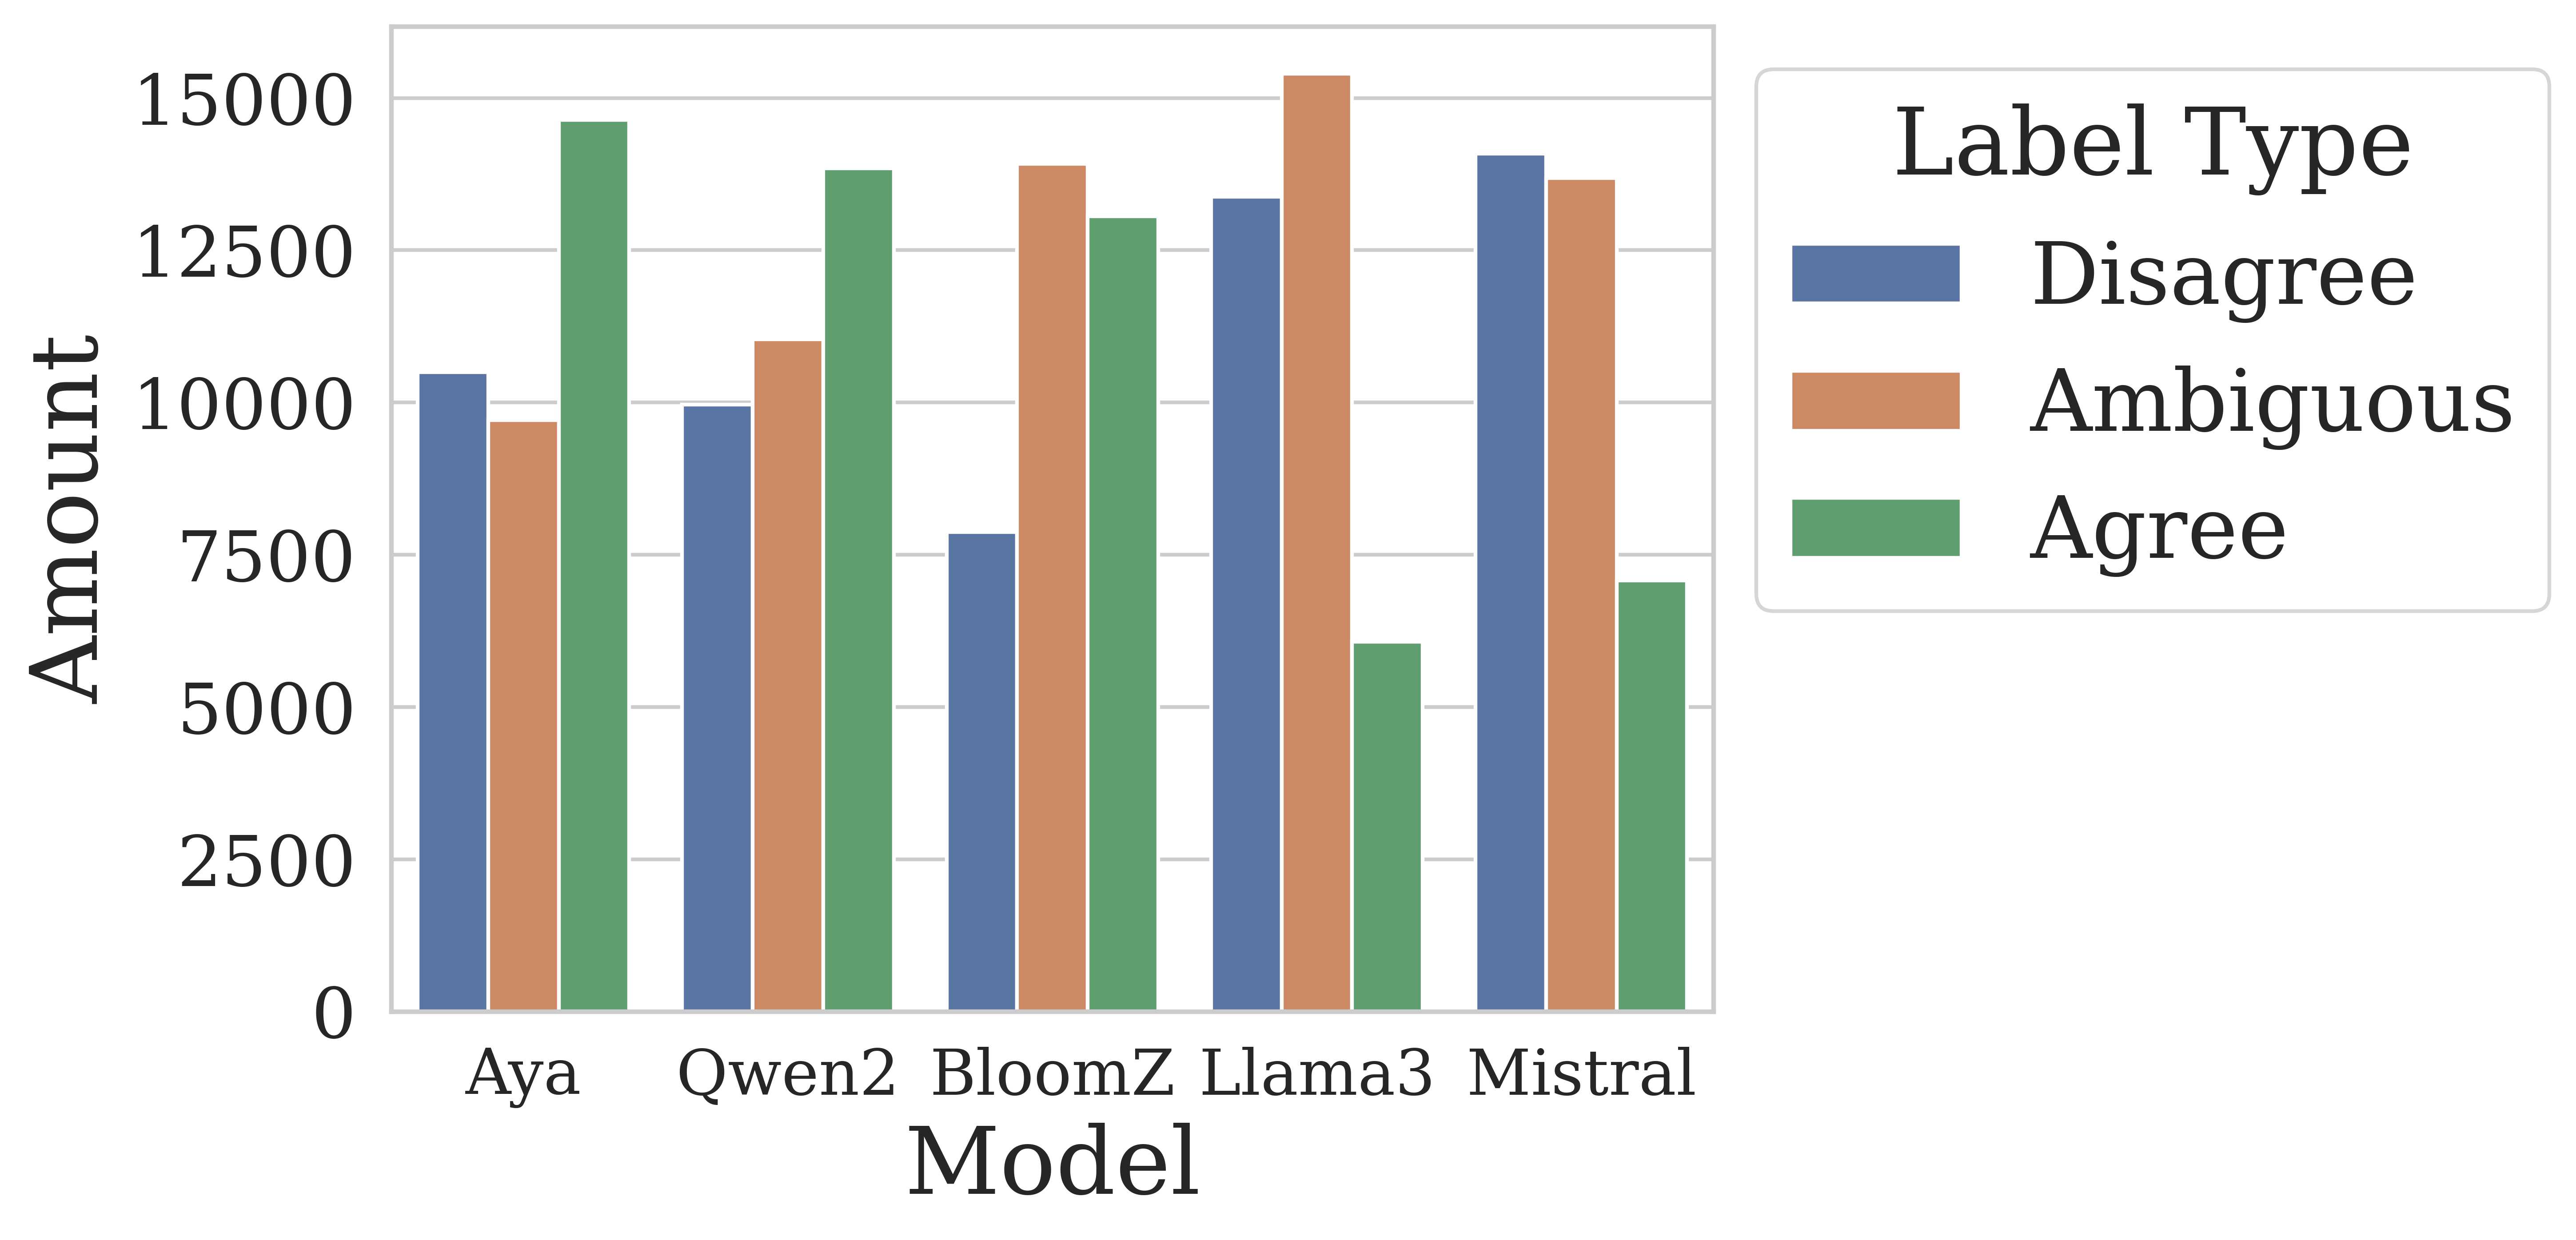

In [140]:
construct_distribution_by_attribute(aggregate_perf(), objective_field="model display name")

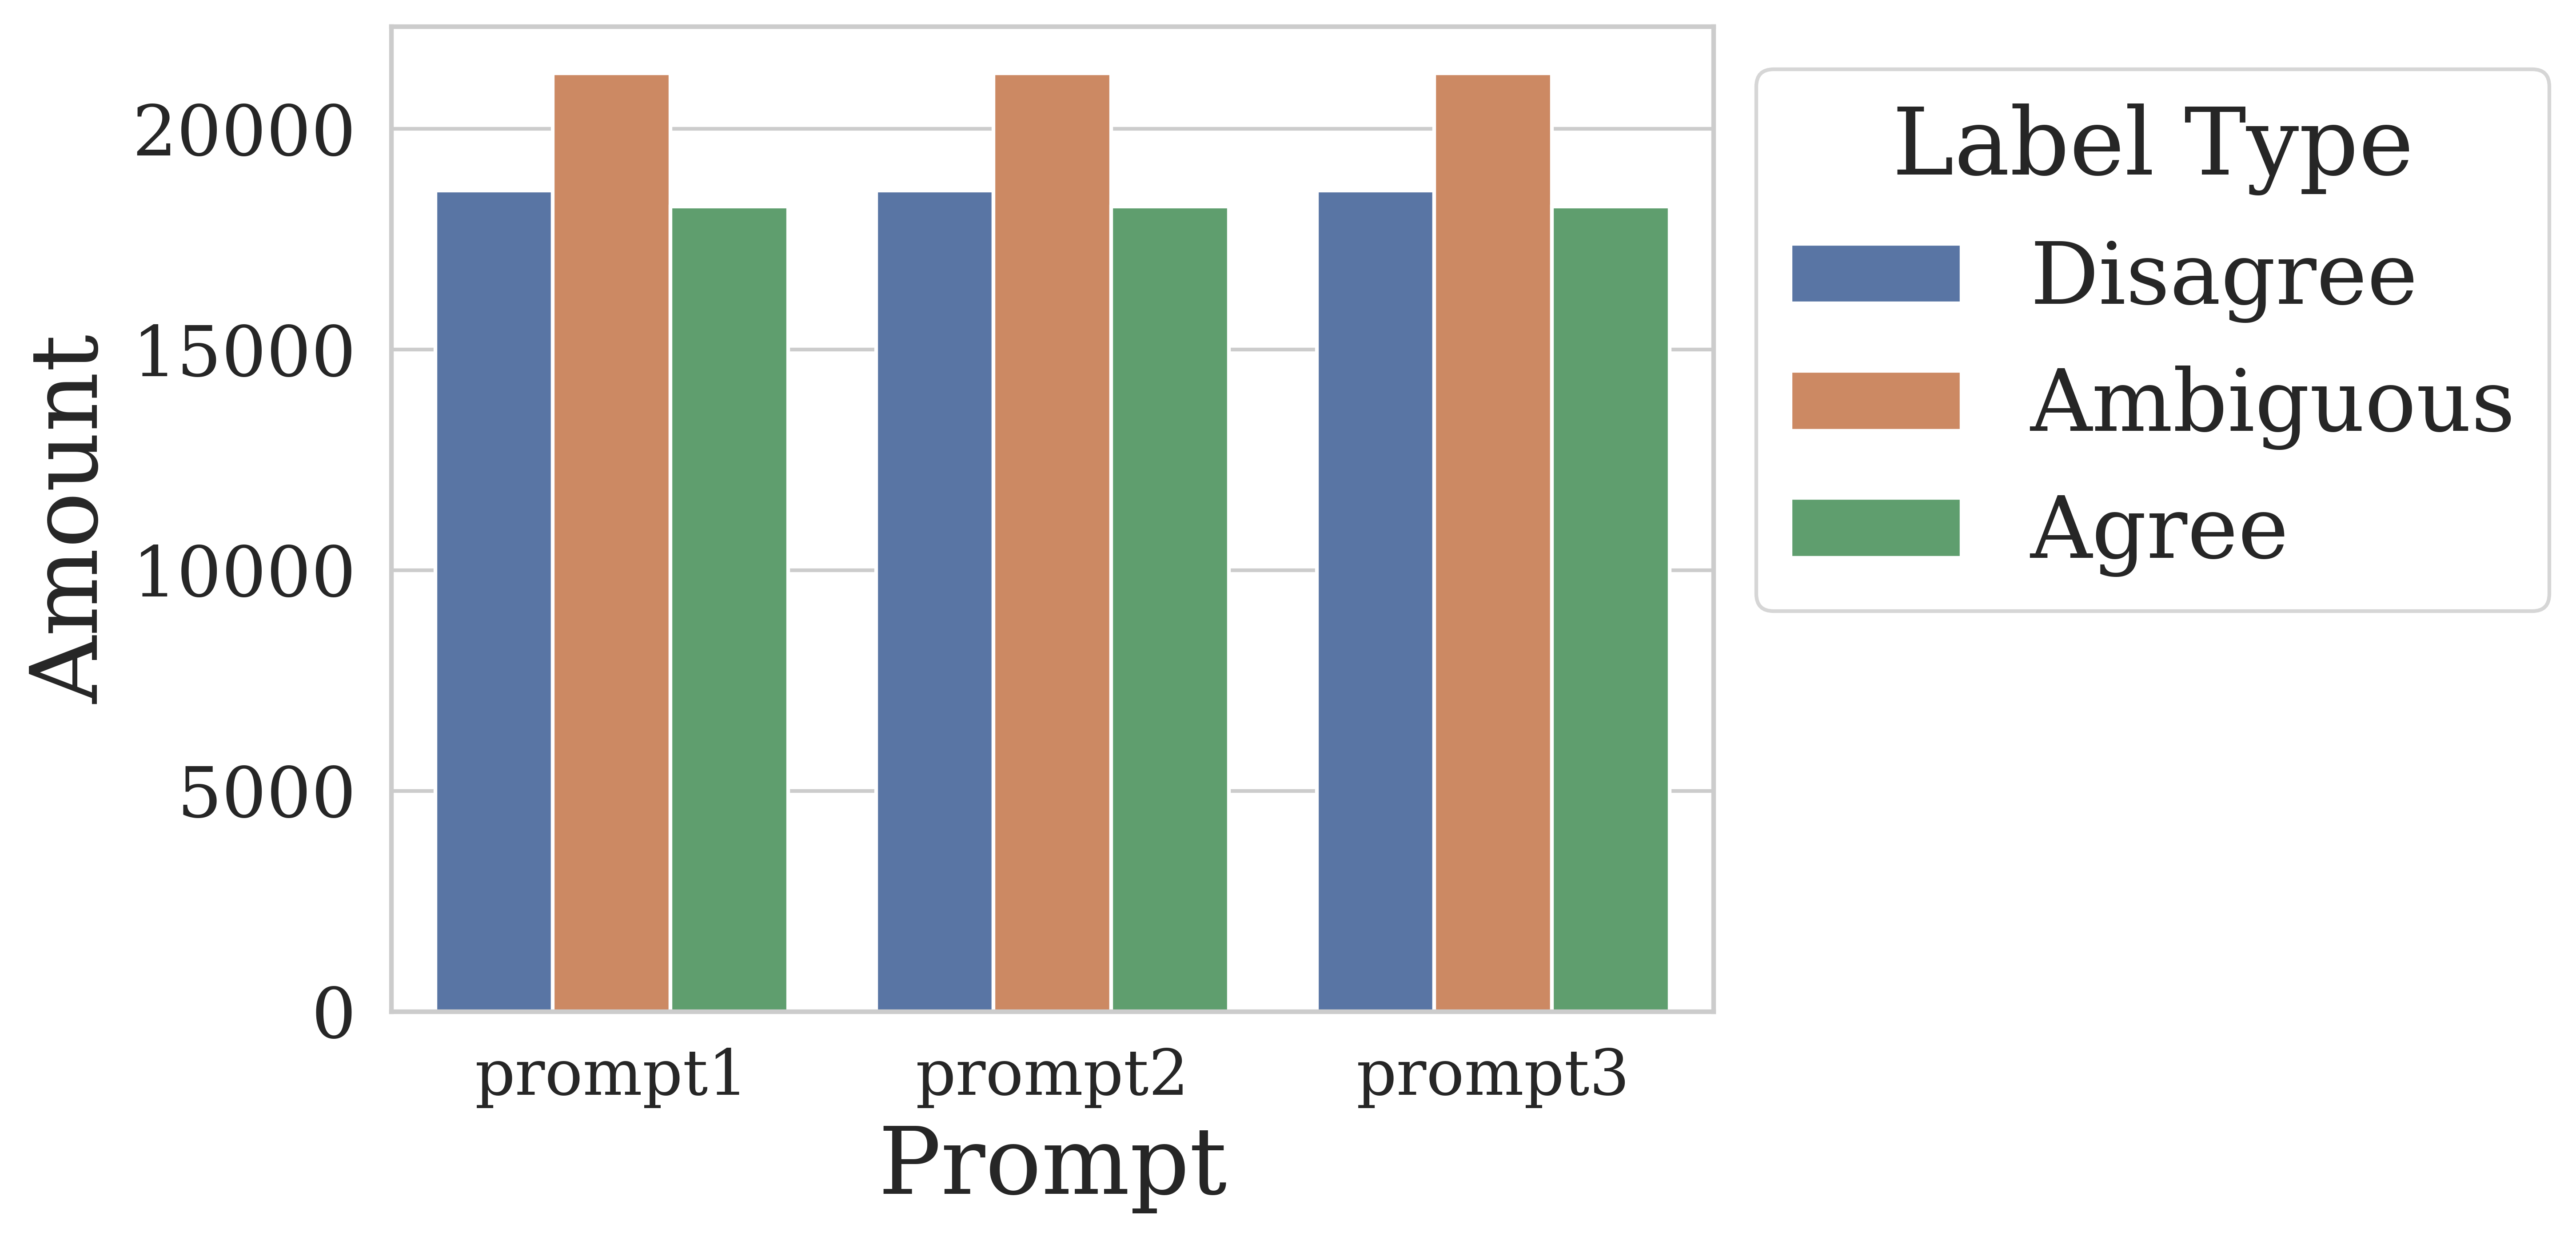

In [143]:
construct_distribution_by_attribute(aggregate_perf(), objective_field="prompt_name")

Takeaway Below: Arabic, Bengali, and Marathi received the most ambiguous output. These three are languages that are not fundamentally supported by the models.
Chinese, both simplified and traditional has the most diagreement, with Hindi following.

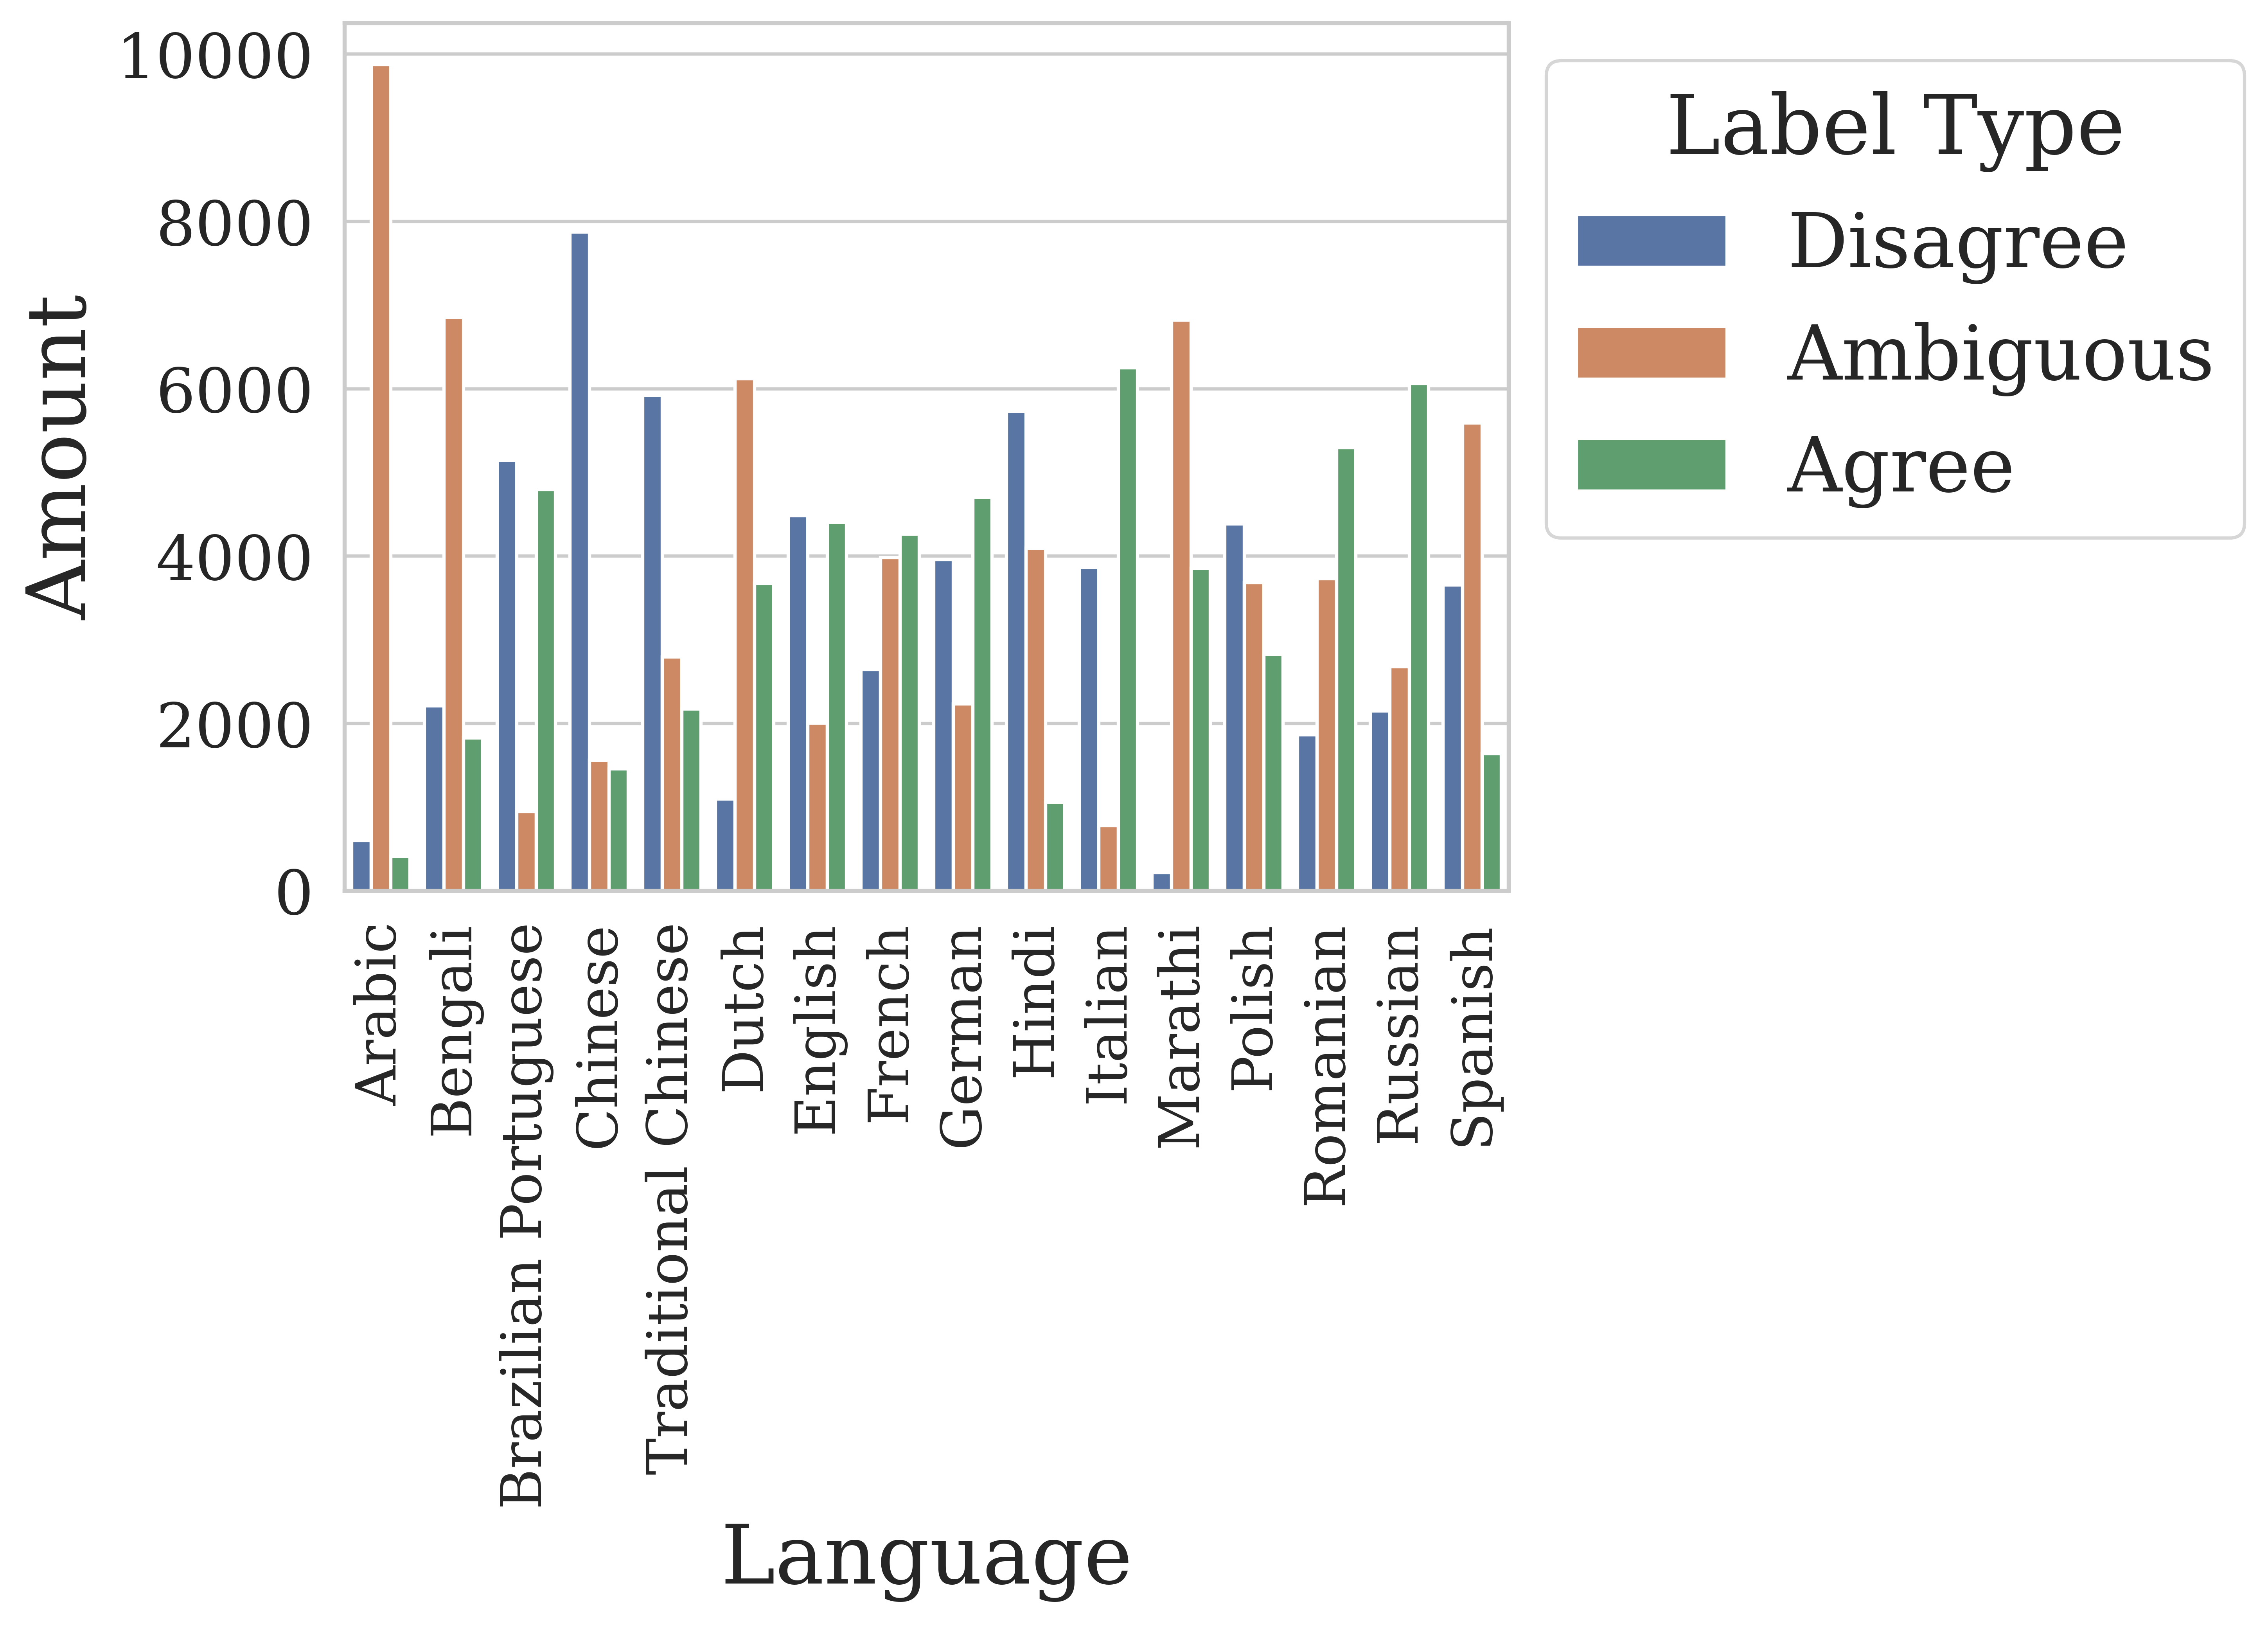

In [146]:
construct_distribution_by_attribute(aggregate_perf(), objective_field="language")

### Language-wise: Does the model tend to agree more in the language of valid regions?

In [182]:
import ast
def get_available_regions_and_langs():
    regions = set()
    langs = set()
    for model_name in MODEL_NAMES:
        for prompt_name in PROMPT_NAMES:
            curr_data = load_prediction(model_name=model_name, promptname=prompt_name)
            for instance in curr_data:
                if instance["stereotype_valid_regions"]:
                    # print(instance["stereotype_valid_regions"])
                    for loc in ast.literal_eval(instance["stereotype_valid_regions"]):
                        regions.add(loc)
                for column in instance.keys():
                    if ": Pred label" in column:
                        langs.add(column.split(": Pred label")[0])
    return list(regions), list(langs)

def linearize_region_language_data():
    res = []
    for model_name in MODEL_NAMES:
        for prompt_name in PROMPT_NAMES:
            curr_data = load_prediction(model_name=model_name, promptname=prompt_name)
            for instance in curr_data:
                for column in instance.keys():
                    if ": Pred label" in column:
                        if instance[column] == 1:
                            pred_pretty = "Agree"
                        elif instance[column] == 0:
                            pred_pretty = "Disagree"
                        else:
                            pred_pretty = "Ambiguous"
                        
                        # For each valid region, create an entry
                        if instance["stereotype_valid_regions"]:
                            for loc in ast.literal_eval(instance["stereotype_valid_regions"]):
                                res.append({"model": model_name,
                                        "model display name": MODEL_DISPLAY_NAMES[model_name],
                                        "pred": instance[column],
                                        "Label Type": pred_pretty,
                                        "language": column.split(": Pred label")[0],
                                        "prompt_name": prompt_name,
                                        "valid_lang": instance["stereotype_origin_langs"],
                                        "valid_region": loc})
    return pd.DataFrame(res)

In [183]:
# Language-wise: Does the model tend to agree more in the language of valid regions?


# Parse for a list of available regions
regions, langs = get_available_regions_and_langs()
print(regions)
print(langs)

['RU', 'NL', 'FR', 'Yemen', '(someone deleted)', 'Iraq', 'UK', 'Egypt', 'PL', 'United States', 'CN', 'HK', 'LB', 'Libya', 'IN', 'Algeria', 'Syria', 'UZ', 'Oman', 'Qatar', 'JP', 'United Arab Emirates', 'Bahrain', 'Saudi Arabia', 'DE', 'Sudan', 'BR', 'Kuwait', 'BE', 'DO', 'IT', 'Mauritania', 'Palestine', 'Morocco', 'Jordan', 'US', 'RO', 'Tunisia']
['Brazilian Portuguese', 'Chinese', 'German', 'French', 'Italian', 'Spanish', 'Bengali', 'English', 'Russian', 'Romanian', 'Polish', 'Hindi', 'Traditional Chinese', 'Dutch', 'Arabic', 'Marathi']


In [199]:
def create_heatmap_data(regions, langs, dataset):
    # Heatmap of [-1, 1] - Avg between disagree, ambiguous, agree?
    # Language v.s. region
    matrix = np.zeros([len(langs), len(regions)])
    for region_idx, region in enumerate(regions):
        for lang_idx, lang in enumerate(langs):
            # Compute the average scores of the language and region
            filtered_df = dataset[(dataset['valid_region'] == region) & (dataset['language'] == lang)]
            matrix[lang_idx, region_idx] = filtered_df["pred"].mean()
    return matrix

<Figure size 3840x2880 with 0 Axes>

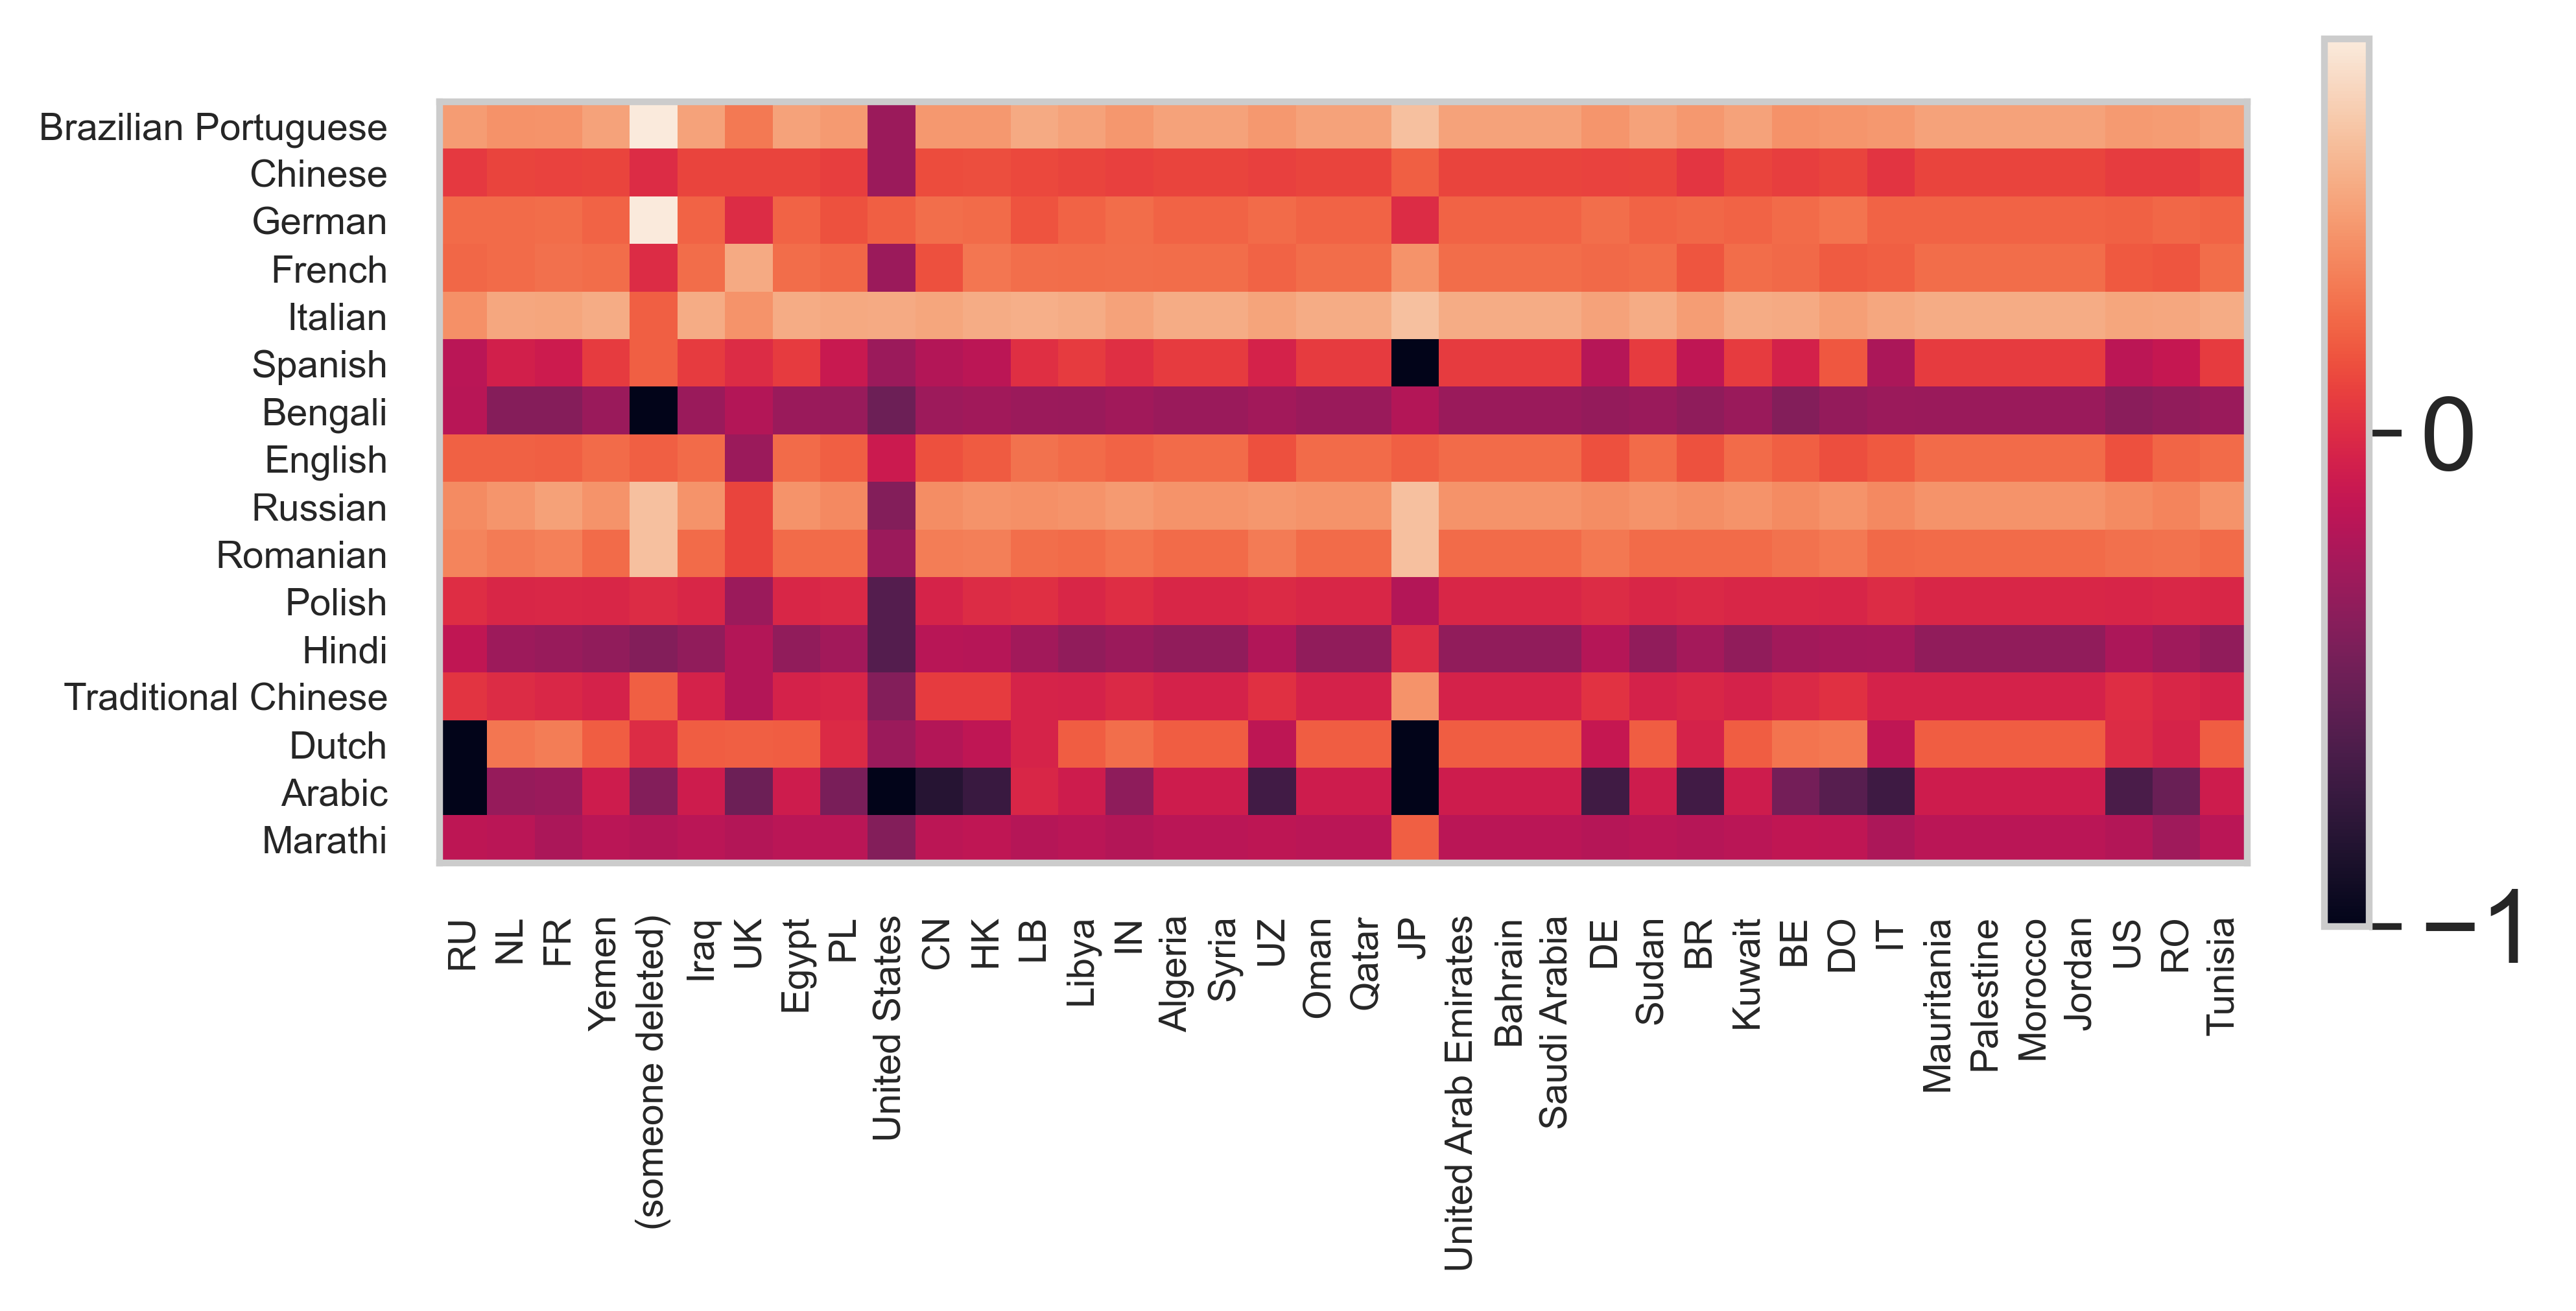

<Figure size 3840x2880 with 0 Axes>

In [203]:
# Mean value of agreement (The closer to 1, the more aggrement of the model with statement is stereotype)
matrix = create_heatmap_data(regions, langs, linearize_region_language_data())
plt.clf()
# sns.set_theme(font_scale=2.1, style='whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots()
im = ax.imshow(matrix)
ax.set_xticks([i for i in range(len(regions))])
ax.set_yticks([i for i in range(len(langs))])
ax.set_xticklabels(regions, rotation='vertical', fontsize=7)
ax.set_yticklabels(langs, fontsize=7)
cbar = fig.colorbar(im, ticks=[-1, 0, 1], fraction=0.023, pad=0.04)
plt.show()
plt.savefig(os.path.join(os.environ['BASE_DIR'], "figures", f"regions_vs_langauge.pdf"), bbox_inches='tight')